# Imports


In [191]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import colors
import sdf
import re
import imageio as imageio
import glob
import tqdm
plt.rcParams["font.size"] = 16
plt.rcParams["figure.figsize"] = (10, 8)

# Parameters


## The Envelope


The envelope of the incident laser field varies according to

$$
    P(t)=
    \begin{cases}
         & \sin^2(\pi t/T) \text{ for } 0 \leq t \le T \\
         & 0         \;      \text{ otherwise }
    \end{cases}
$$


with $T = 20\tau$. See below to see what $\tau$ means and how the envelope looks.


## Physical Constants


In [192]:
m = 9.10938356e-31
e = 1.60217662e-19
c = 299792458
PI = np.pi
epsilon = 8.85e-12

## Constants From Simulation


In [193]:
DATA_DIR = "../harmonics/run2"
with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data=myfile.read()

The parameters which we want to extract are:

- Wavelength: `lambda`
- Laser Time: `las_time`
- Vector Potential: `a0`
- The density factor: `factor`
- Number of Cells: `nx`
- Simulation End Time: `t_end`
- Size of Box: `x_min`
- dt: `dt_snapshot`


In [194]:
def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None

In [195]:
LAMBD= find_value("lambda0")*1e-6
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("t_end"))
DT = find_value("dt_snapshot")*1e-15
A0 = find_value("a0")
FACTOR = int(find_value("factor"))
NX = int(find_value("nx"))
X_MIN = -int(find_value("x_min"))

print("Values from input.deck:")
print("lambda0 = ", LAMBD)
print("laser_time = ", LAS_TIME)
print("t_end = ", T_MAX)
print("dt_snapshot = ", DT)
print("a0 = ", A0)
print("factor = ", FACTOR)
print("nx = ", NX)
print("x_min = ", X_MIN)

Values from input.deck:
lambda0 =  1e-06
laser_time =  20
t_end =  40
dt_snapshot =  8e-17
a0 =  0.5
factor =  4
nx =  16000
x_min =  -20


## Calculated Constants


In [196]:
omega0 = 2*PI*c/LAMBD
tau = 2*PI/omega0
nc = epsilon*m*omega0**2/e**2
Er = m * omega0 * c / e
n0 = FACTOR*nc
LAS_TIME = LAS_TIME*tau
print("Calculated Values for the simulation are:")
print("omega0 = ", omega0)
print("tau = ", tau)
print("nc = ", nc)
print("Er = ", Er)
print("n0 = ", n0)

Calculated Values for the simulation are:
omega0 =  1883651567308853.2
tau =  3.3356409519815205e-15
nc =  1.1143269197457677e+27
Er =  3210701072782.3525
n0 =  4.457307678983071e+27


## Values for FT


In [197]:
omega_to_resolve = 20*omega0
f_max_to_resolve = omega_to_resolve/(2*PI)
dt_max_to_resolve = 1/(2*f_max_to_resolve)
print(f"The maximum time step for resolution is {dt_max_to_resolve*1e15} femto seconds")

The maximum time step for resolution is 0.08339102379953801 femto seconds


In [198]:
f_max = 1/(DT)
omega_max = 2*np.pi*f_max
omega_max/omega0

41.69551189976901

## Other Variables


In [199]:
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
len(ALL_FILES)

1669

In [200]:
X = np.linspace(X_MIN, -X_MIN, NX)
T = np.linspace(0, T_MAX, len(ALL_FILES))

# Plots and Data


In [201]:
data = sdf.read(ALL_FILES[100])

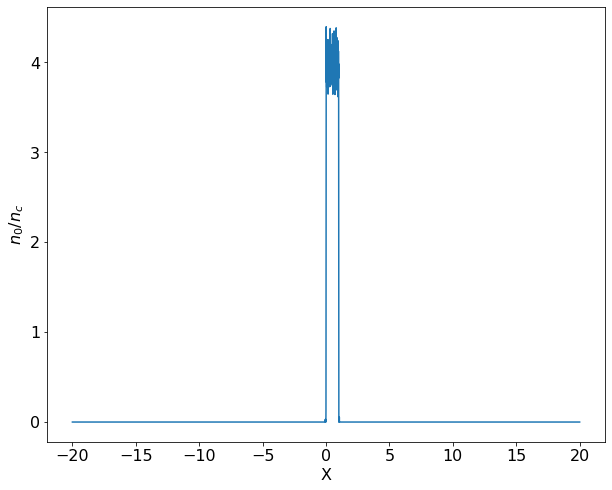

In [202]:
plt.plot(X, data.Derived_Number_Density_Electron.data/nc)
plt.xlabel("X")
plt.ylabel("$n_0/n_c$");

In [203]:
def get_field(id, component="y"):
    raw_data = sdf.read(ALL_FILES[id])
    comp = {
        "x": raw_data.Electric_Field_Ex,
        "y": raw_data.Electric_Field_Ey,
        "z": raw_data.Electric_Field_Ez,
    }
    field = comp[component].data
    return field


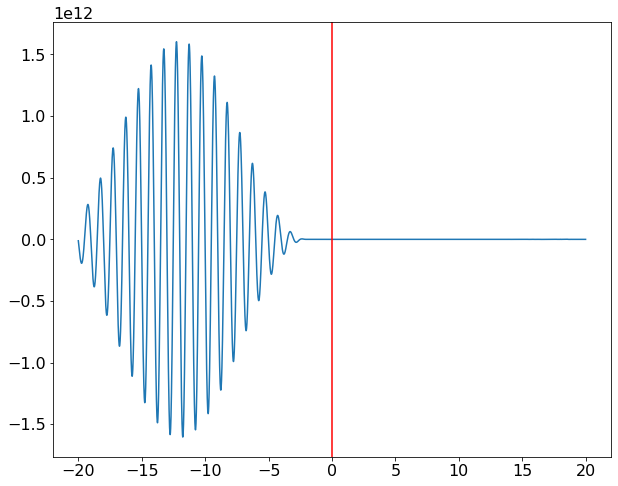

In [204]:
Ey = get_field(750)
plt.plot(X, Ey)
plt.axvline(0, color="red")
plt.show()


In [205]:
Et0 = np.zeros(len(ALL_FILES))
Et1 = np.zeros(len(ALL_FILES))
Et2 = np.zeros(len(ALL_FILES))
for i in tqdm.tqdm(range(len(ALL_FILES)), desc = "Getting data..."):
    data = sdf.read(ALL_FILES[i])
    ey = data.Electric_Field_Ey.data
    Et0[i] = ey[0]
    Et1[i] = ey[4000]
    Et2[i] = ey[8000]

Getting data...: 100%|██████████| 1669/1669 [00:04<00:00, 372.40it/s]


# Fourier Analysis


In [206]:
Et0 = Et0/np.max(Et0)
Et1 = Et1/np.max(Et1)
Et2 = Et2/np.max(Et2)

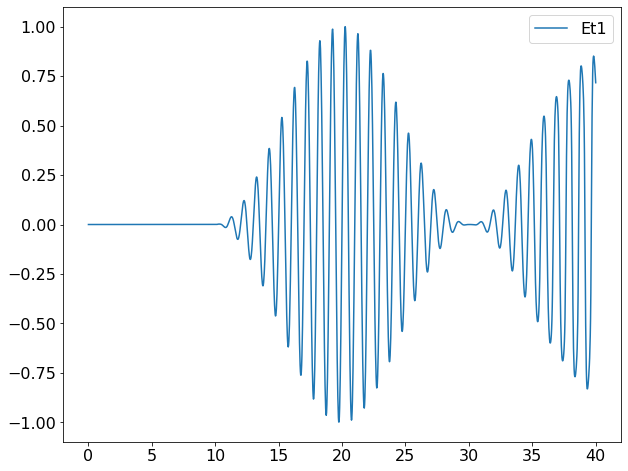

In [207]:
plt.plot(T, Et1, label="Et1")
plt.legend();


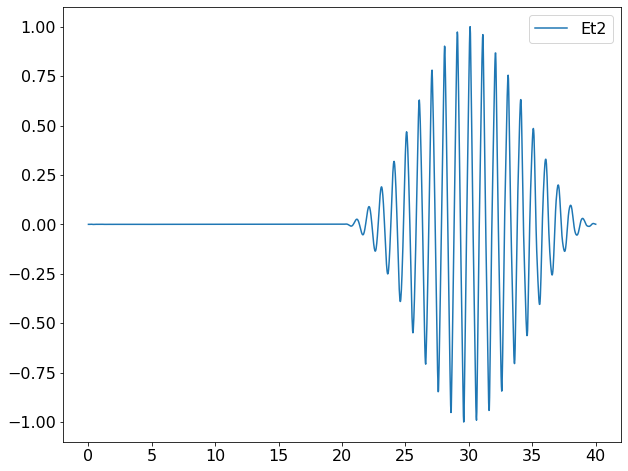

In [208]:
plt.plot(T, Et2, label="Et2")
plt.legend();


## FT


In [209]:
y0 = np.fft.fft(Et0)
y1 = np.fft.fft(Et1)
y2 = np.fft.fft(Et2)

In [210]:
y1_shift = np.fft.fftshift(y1)
y2_shift = np.fft.fftshift(y2)
y0_shift = np.fft.fftshift(y0)
y1_f = np.abs(y1_shift)
y2_f = np.abs(y2_shift)
y0_f = np.abs(y0_shift)

In [211]:
omega = np.linspace(-omega_max/2, omega_max/2, len(ALL_FILES))

In [212]:
omega_max/omega0

41.69551189976901

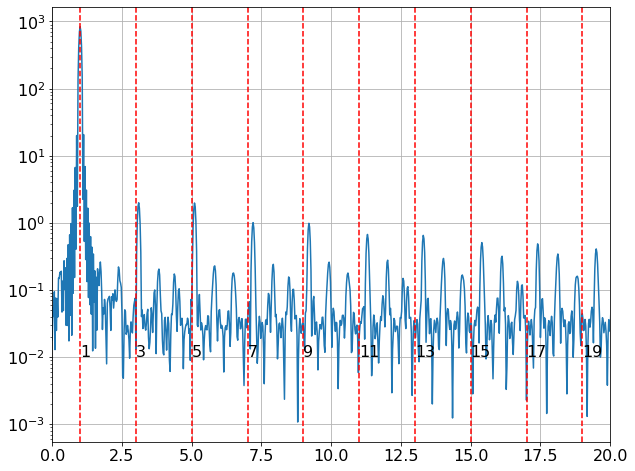

In [213]:
plt.plot(omega/omega0, 2*np.abs(y0_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()

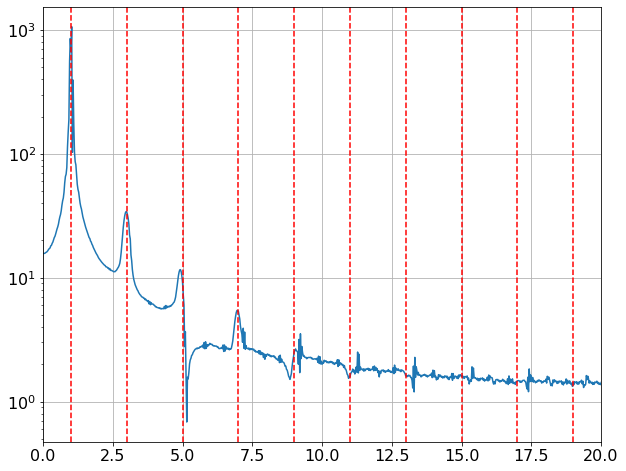

In [214]:
plt.plot(omega/omega0, 2*np.abs(y1_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()

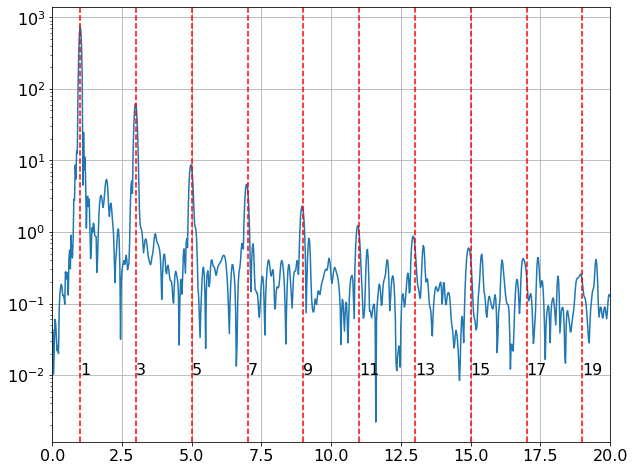

In [215]:
plt.plot(omega/omega0, 2*np.abs(y2_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()

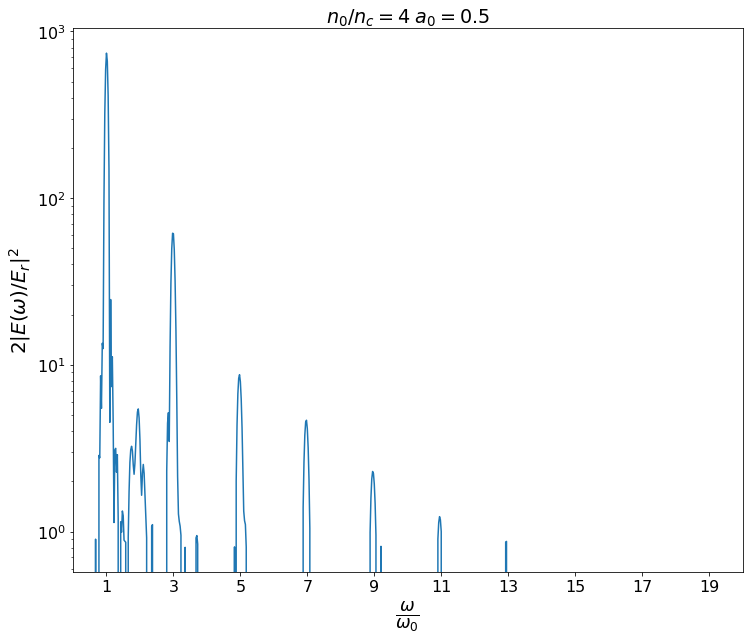

In [219]:
y3 = 2*np.abs(y2_f)*2
mask = y3<0.8
y3[mask] = 0
font_dict = {
    'fontsize' : 20
}
plt.figure(figsize=(12,10))
plt.plot(omega/omega0, y3)
plt.yscale("log")
points = np.arange(1,21,2)
plt.xticks(points)
plt.xlim(0,20)
plt.title(rf"$n_0/n_c={FACTOR}\;a_0={A0}$")
plt.ylabel(r"$2|E(\omega)/E_r|^2$", fontdict={
    'fontsize' : 20
})
plt.xlabel(r"$\frac{\omega}{\omega_0}$", fontdict={
    'fontsize' : 25
})
file_name = DATA_DIR.split("/")[-1]+".jpg"
plt.savefig(file_name)
# plt.grid()